In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import pandas as pd
import numpy as np
import os
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
NUM_EPOCH = 100
# NUM_CLASSES = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.0001

In [3]:
data_file = 'data/ecog_mel60_bi_dataset.pkl'
with open(data_file, 'rb') as f:
    dataset = pickle.load(f)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=dataset[0],
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset[1],
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [5]:
# class BinarizedF(Function):
#     def forward(self, input):
#         self.save_for_backward(input)
#         a = torch.ones_like(input)
#         b = -torch.ones_like(input)
#         output = torch.where(input>=0,a,b)
#         return output
#     def backward(self, output_grad):
#         input, = self.saved_tensors
#         input_abs = torch.abs(input)
#         ones = torch.ones_like(input)
#         zeros = torch.zeros_like(input)
#         input_grad = torch.where(input_abs<=1,ones, zeros)
#         return input_grad

In [40]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3, padding=1)
#         self.mp = nn.MaxPool2d(3)
        self.gap = nn.AvgPool2d(1)
        self.fc = nn.Linear(120000, 384)
#         self.fc2 = nn.Linear(120000, 6)
        
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        in_size = x.size(0)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = self.gap(x2)
        x4 = x3.view(in_size, -1)
        x5 = self.fc(x4)
        with torch.no_grad():
            x5 =x5
#         x5 = torch.squeeze(x5)
#         return (x5>0.5).float().requires_grad_()
        return x5

In [41]:
model = Net()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
model.eval()

Net(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AvgPool2d(kernel_size=1, stride=1, padding=0)
  (fc): Linear(in_features=120000, out_features=384, bias=True)
)

In [42]:
# Train the model
total_step = len(train_loader)
train_loss_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(NUM_EPOCH):
    model.train()
    for i, (ecog, mel) in enumerate(train_loader):
#         images = images.to(device)
#         labels = labels.to(device)
        
        # Forward pass
#         outputs = model(images).double()
#         labels = labels.long()
        outputs = model(ecog)
        labels = mel
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            train_loss_list.append(loss.item())
            print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, NUM_EPOCH, loss.item()))
#             model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
#             with torch.no_grad():
#                 correct = 0
#                 total = 0
#                 for images, labels in test_loader:
#                     images = images.to(device)
#                     labels = labels.to(device)
#                     outputs = model(images)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 print('Test Accuracy of the model on the 250 test images: {} %'.format(100 * correct / total))
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
#         data, target = Variable(data, volatile=True), Variable(target)
#         data = data.to(device)
#         target = target.to(device)
        output = model(data)
        # sum up batch loss
        target = target
        test_loss += F.l1_loss(output, target, size_average=False).data
        # get the index of the max log-probability
#         pred = output.data.max(1, keepdim=True)[1]
#         correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss.item())
#     test_accuracy_list.append((100. * correct / len(test_loader.dataset)).item())
    print('\nTest set: Average loss: {:.4f}\n'.format(
        test_loss))
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                    .format(epoch+1, NUM_EPOCH, i+1, total_step, loss.item()))


Epoch [1/100], Loss: 0.0623

Test set: Average loss: 22.0313

Epoch [2/100], Loss: 0.0554

Test set: Average loss: 18.3926

Epoch [3/100], Loss: 0.0468

Test set: Average loss: 14.9152

Epoch [4/100], Loss: 0.0387

Test set: Average loss: 11.9964

Epoch [5/100], Loss: 0.0310

Test set: Average loss: 10.6345

Epoch [6/100], Loss: 0.0280

Test set: Average loss: 8.7203

Epoch [7/100], Loss: 0.0202

Test set: Average loss: 7.8437

Epoch [8/100], Loss: 0.0201

Test set: Average loss: 6.7273

Epoch [9/100], Loss: 0.0170

Test set: Average loss: 6.1926

Epoch [10/100], Loss: 0.0162

Test set: Average loss: 5.7654

Epoch [11/100], Loss: 0.0138

Test set: Average loss: 5.5885

Epoch [12/100], Loss: 0.0151

Test set: Average loss: 5.3643

Epoch [13/100], Loss: 0.0144

Test set: Average loss: 5.2467

Epoch [14/100], Loss: 0.0123

Test set: Average loss: 5.0464

Epoch [15/100], Loss: 0.0119

Test set: Average loss: 4.9990

Epoch [16/100], Loss: 0.0117

Test set: Average loss: 4.9429

Epoch [17/10

In [46]:
img = dataset[1][1][0]
img_arr = np.asarray([t.numpy() for t in img])
img = Variable(torch.from_numpy(img_arr)).view(1,96,125)
# img = Variable(img).view(1,96,125)
print(img)

tensor([[[0.5899, 0.5404, 0.5082,  ..., 0.5543, 0.6250, 0.6580],
         [0.5185, 0.4716, 0.4357,  ..., 0.4995, 0.5500, 0.5897],
         [0.4580, 0.4169, 0.3887,  ..., 0.4618, 0.5055, 0.5173],
         ...,
         [0.4378, 0.4246, 0.3890,  ..., 0.4505, 0.5450, 0.6006],
         [0.3707, 0.3522, 0.3064,  ..., 0.3600, 0.4493, 0.5129],
         [0.3951, 0.3696, 0.3289,  ..., 0.3244, 0.3983, 0.4680]]])


In [47]:
mel_out = model(img)

In [48]:
print(mel_out)

tensor([[-7.3409e-03,  4.9698e-03,  4.0158e-03,  7.7791e-03, -2.0392e-03,
         -2.2999e-03,  2.1482e-03, -2.9461e-03,  6.5758e-03,  1.1294e-02,
          1.0148e-02,  8.7027e-04,  1.8357e-03, -4.5515e-03, -8.0420e-04,
          8.0880e-03,  1.7540e-03, -5.5693e-03,  4.8609e-03,  2.6625e-03,
          1.2221e-03, -2.6295e-05, -6.0669e-03,  2.1152e-03,  4.4100e-03,
         -5.6866e-03, -8.5445e-03, -1.4103e-03, -2.3485e-03,  2.6079e-03,
          4.3043e-03, -9.3719e-03, -1.1054e-03, -1.8285e-03,  5.8138e-03,
         -3.7034e-03, -1.0881e-02,  2.1718e-03, -6.8471e-03,  2.6267e-03,
         -7.7965e-03,  6.5234e-03,  2.2215e-03,  4.7486e-04, -7.3440e-03,
          3.7997e-03, -7.4452e-03,  4.7899e-03, -1.8600e-03, -4.1764e-03,
         -1.3390e-03,  5.6570e-04, -6.7148e-03, -4.1869e-03,  6.3286e-03,
          2.5897e-03, -7.8124e-03, -2.9254e-03,  3.3301e-03, -8.1339e-03,
          4.5755e-04,  6.2220e-04, -1.7682e-03, -8.5711e-03,  2.5575e-03,
          2.6676e-03,  8.8095e-03,  4.

In [52]:
mel_out_np = mel_out.detach().numpy()
mel_out_np = mel_out_np.reshape(128,3)
np.save('data/mel_out_np_81.npy', mel_out_np)

In [50]:
from matplotlib import pyplot as plt
%matplotlib inline 

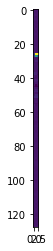

In [51]:
plt.imshow(mel_out_np, interpolation='nearest')
plt.show()